# Intro  
L'ensemble de données FD002 est le deuxième de la série.

Trajectoires d'entraînement : 260

Trajectoires de test : 259

Conditions : SIX

Modes de défaillance : UN (Dégradation HPC)





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Commençons par charger les données et démarrer notre Analyse Exploratoire des Données (EDA) en inspectant les premières lignes, afin de nous familiariser avec la structure des données.


In [ ]:
# define filepath to read data
dir_path = './CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD002.txt'), sep='\s+', header=None, names=col_names)
x_test = pd.read_csv((dir_path+'test_FD002.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD002.txt'), sep='\s+', header=None, names=['RUL'])

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [ ]:
#Supprimer toutes les lignes supplémentaires et conserver uniquement le dernier cycle de chaque moteur.
x_test=x_test.groupby('unit_nr').last().reset_index()
x_test.shape

(259, 26)

In [ ]:
# Imputer avec la moyenne
train.fillna(train.mean(), inplace=True)
x_test.fillna(x_test.mean(), inplace=True)
y_test.fillna(y_test.mean(), inplace=True)



##Checking for missing values:

In [ ]:
def check_missing_values(data):
    print('Verifing the existance of null data:')
    return data.isnull().sum()

print(check_missing_values(train))

Verifing the existance of null data:
unit_nr        0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


## Descriptive statistics

In [ ]:
# inspect unit_nr
train[index_names].describe()

,unit_nr,time_cycles
count,53759.000000,53759.000000
mean,131.082981,109.154746
std,74.463862,69.180569
min,1.000000,1.000000
25%,68.000000,52.000000
50%,131.000000,104.000000
75%,195.000000,157.000000
max,260.000000,378.000000


In [ ]:
# inspect time cycles
train[index_names].groupby('unit_nr').max().describe()

,time_cycles
count,260.000000
mean,206.765385
std,46.782198
min,128.000000
25%,174.000000
50%,199.000000
75%,230.250000
max,378.000000


In [ ]:
# inspect settings
train[setting_names].describe()

,setting_1,setting_2,setting_3
count,53759.000000,53759.000000,53759.000000
mean,23.998407,0.572056,94.046020
std,14.747376,0.310016,14.237735
min,0.000000,0.000000,60.000000
25%,10.004600,0.250700,100.000000
50%,25.001300,0.700000,100.000000
75%,41.998000,0.840000,100.000000
max,42.008000,0.842000,100.000000


In [ ]:
# inspect sensor values
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,53759.0,472.910207,26.389707,445.0000,445.0000,462.5400,491.1900,518.6700
s_2,53759.0,579.672399,37.289399,535.5300,549.5700,555.9800,607.3400,644.5200
s_3,53759.0,1419.971013,105.946341,1243.7300,1352.7600,1369.1800,1499.3700,1612.8800
s_4,53759.0,1205.442024,119.123428,1023.7700,1123.6550,1138.8900,1306.8500,1439.2300
s_5,53759.0,8.031986,3.613839,3.9100,3.9100,7.0500,10.5200,14.6200
s_6,53759.0,11.600746,5.431802,5.7100,5.7200,9.0300,15.4900,21.6100
s_7,53759.0,282.606787,146.005306,136.8000,139.9350,194.6600,394.0800,555.8200
s_8,53759.0,2228.879188,145.209816,1914.7700,2211.8800,2223.0700,2323.9600,2388.3900
s_9,53759.0,8525.200837,335.812013,7985.5600,8321.6600,8361.2000,8778.0300,9215.6600
s_10,53759.0,1.094962,0.127469,0.9300,1.0200,1.0200,1.2600,1.3000


In [ ]:
# before we start plotting the data, let's compute RUL

In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,148
1,1,2,147
2,1,3,146
3,1,4,145
4,1,5,144


## Plotting

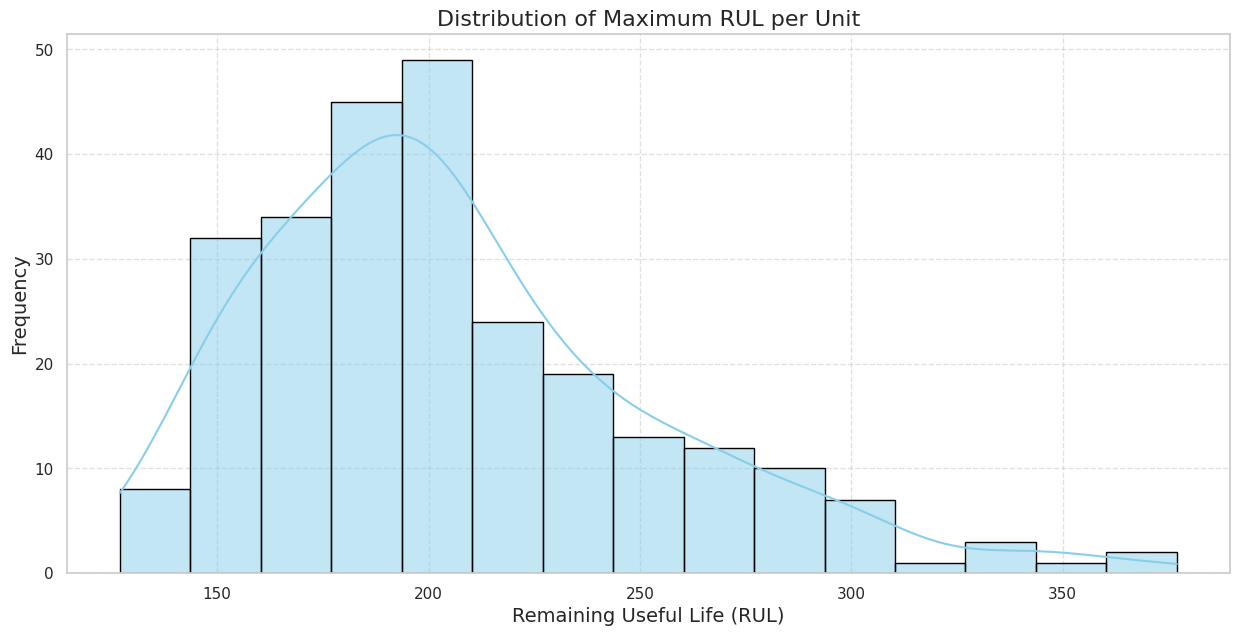

In [ ]:
#plotting
#faire des represetation graphique
# est important pour comprendre les districutions
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
# Configuration du style pour améliorer l'apparence
sns.set_theme(style="whitegrid")

# Histogramme avec des ajustements
plt.figure(figsize=(15, 7))
sns.histplot(df_max_rul['RUL'], bins=15, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Maximum RUL per Unit', fontsize=16)
plt.xlabel('Remaining Useful Life (RUL)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [ ]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name,
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'] semblent pertinents.

Il est temps de créer notre modèle de référence en prenant en compte tous les capteurs contenant des informations liées à la Durée de Vie Restante (RUL).

## Feature extraction



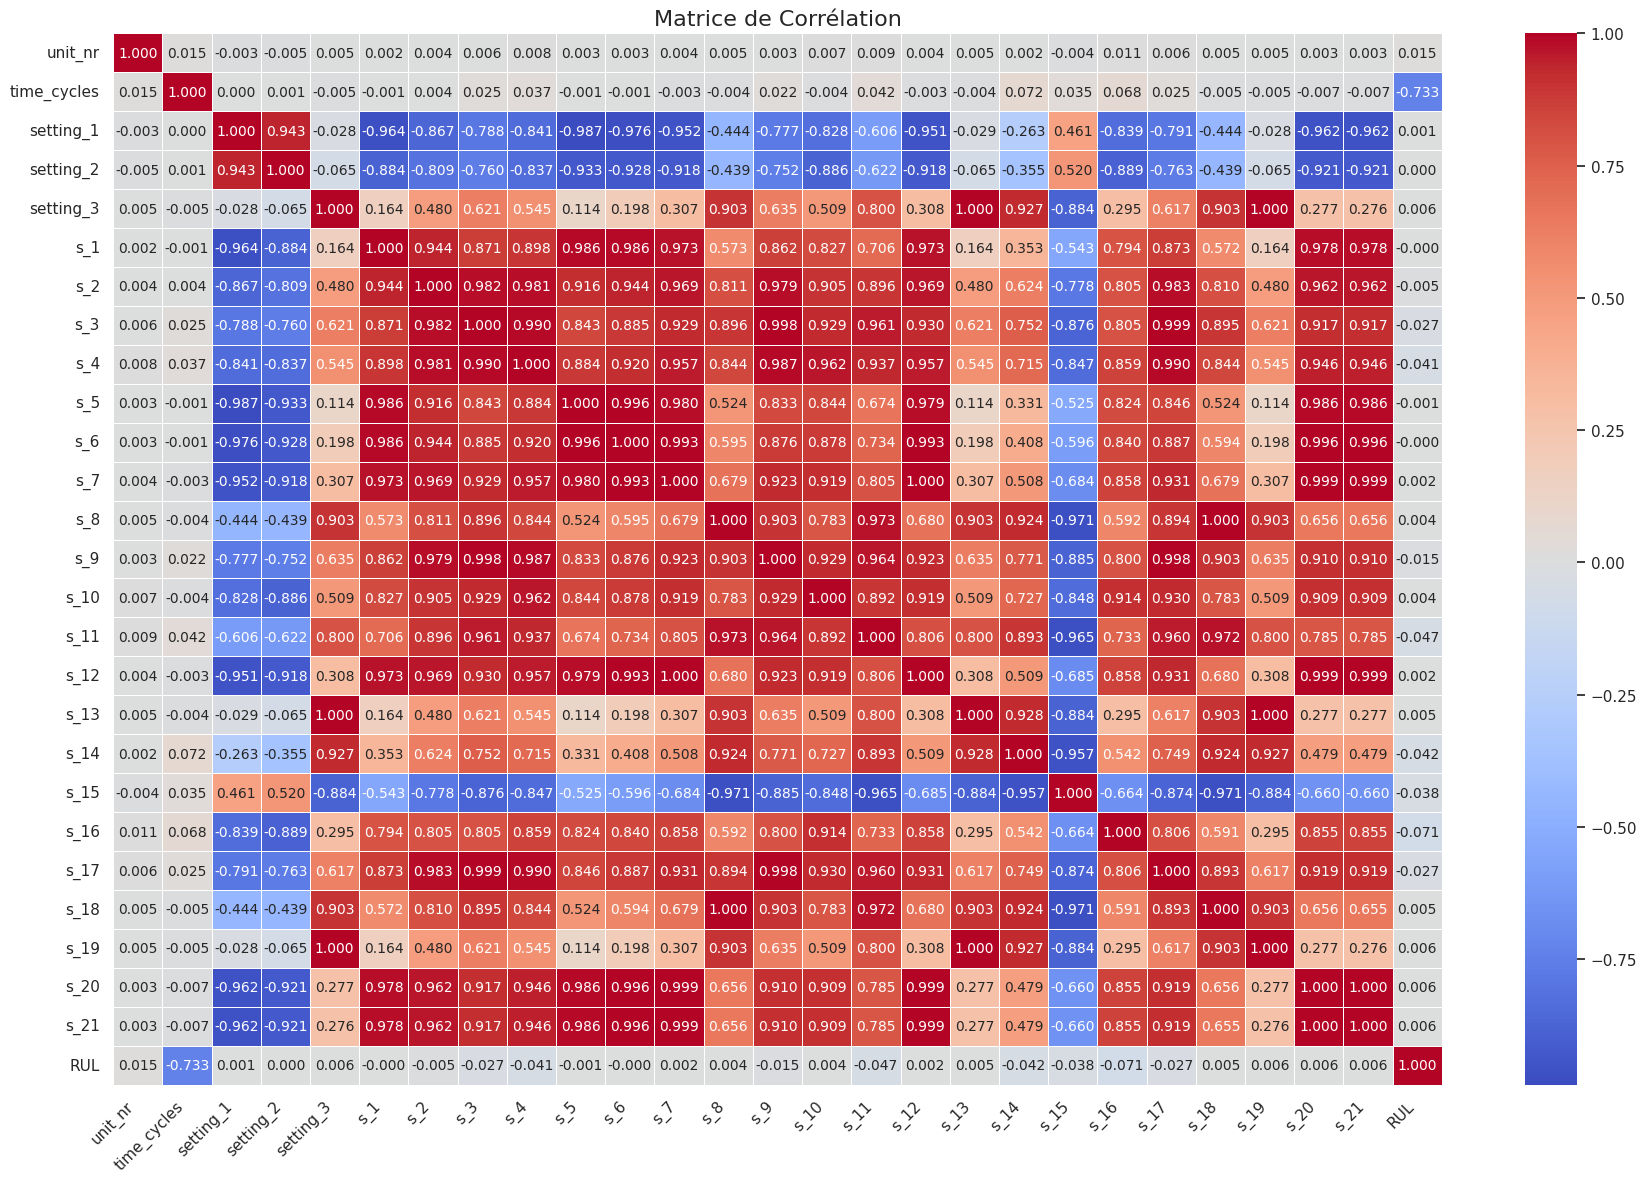

In [ ]:
def corr_matrix(data):

    plt.figure(figsize=(18, 12))  # Augmente la taille de la figure


    sns.heatmap(
        data.corr(),
        annot=True,
        fmt=".3f",  # Limite les nombres à 3 décimales
        cmap='coolwarm',
        annot_kws={"size": 10},  # Définit la taille des annotations
        linewidths=0.5  # Ajoute des séparateurs entre les cellules
    )
    plt.xticks(rotation=45, ha='right')  # Rend les labels plus lisibles
    plt.yticks(rotation=0)  # Labels y en orientation horizontale
    plt.title("Matrice de Corrélation", fontsize=16)  # Titre plus lisible
    plt.tight_layout()  # Évite les débordements
    plt.show()

# Utilisation
corr_matrix(train)


In [ ]:
# Calculer la matrice de corrélation
correlation = train.corr()

# Sélectionner les caractéristiques fortement corrélées avec 'RUL'
train_relevant_features = correlation[abs(correlation['RUL']) >= 0.02]

# Extraire uniquement la colonne pour 'RUL'
train_relevant_features['RUL']


,RUL
time_cycles,-0.733383
s_3,-0.026942
s_4,-0.040978
s_11,-0.046950
s_14,-0.042325
s_15,-0.038455
s_16,-0.071352
s_17,-0.027031
RUL,1.000000


In [ ]:
# Création d'une liste contenant uniquement les caractéristiques importantes
list_relevant_features = train_relevant_features.index

list_relevant_features = list_relevant_features[1:]  # Exclut 'RUL' de la liste

# Conserver uniquement ces caractéristiques importantes dans le jeu d'entraînement
train = train[list_relevant_features]

# Séparer le jeu d'entraînement en x_train (caractéristiques) et y_train (RUL)
y_train = train['RUL']
x_train = train.drop(['RUL'], axis=1)

# Conserver uniquement les colonnes/caractéristiques de x_train dans le jeu de test
x_test = x_test[x_train.columns]

# Affichage des premières lignes de x_train
x_train.head()


,s_3,s_4,s_11,s_14,s_15,s_16,s_17
0,1358.61,1137.23,42.02,8048.56,9.3461,0.02,334
1,1353.22,1125.78,42.20,8072.30,9.3774,0.02,330
2,1256.76,1047.45,36.69,7864.87,10.8941,0.02,309
3,1354.03,1126.38,41.96,8068.66,9.3528,0.02,329
4,1257.71,1047.93,36.89,7861.23,10.8963,0.02,309




## Standardisation

In [ ]:
# Premièrement, créer une fonction d'évaluation
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse, variance

In [ ]:
# Standardisation des caractéristiques
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_trans = sc.fit_transform(x_train)
x_test_trans = sc.transform(x_test)


## Régression linéaire

train set RMSE:54.279477131365354, R2:0.38438224711170155
test set RMSE:41.45940129338869, R2:0.4056750919536579


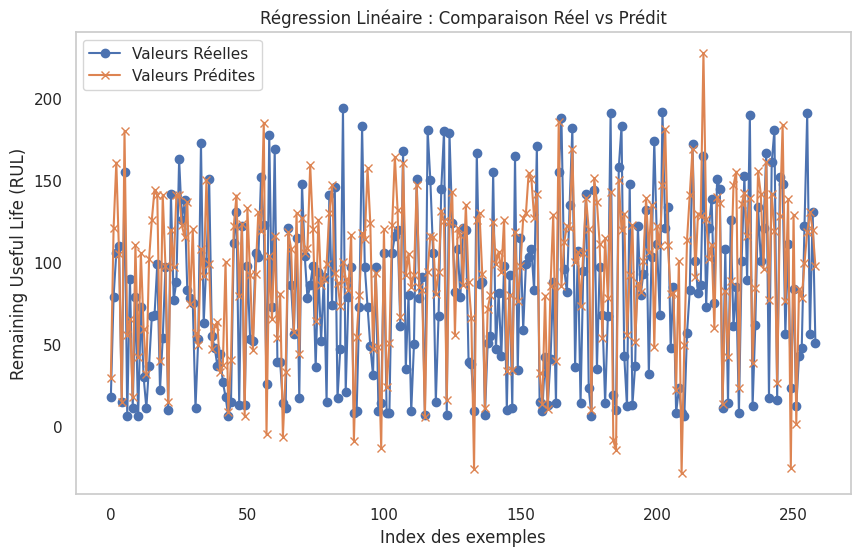

In [ ]:
# Modèle de régression linéaire
from sklearn.linear_model import LinearRegression
y_train_clipped = y_train.clip(upper =125)
lm = LinearRegression()
lm.fit(x_train_trans, y_train)

# Prédire et évaluer
y_hat_train = lm.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Régression Linéaire : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

train set RMSE:29.585701881553295, R2:0.4957841349239229
test set RMSE:38.91424768398361, R2:0.4764054023398656


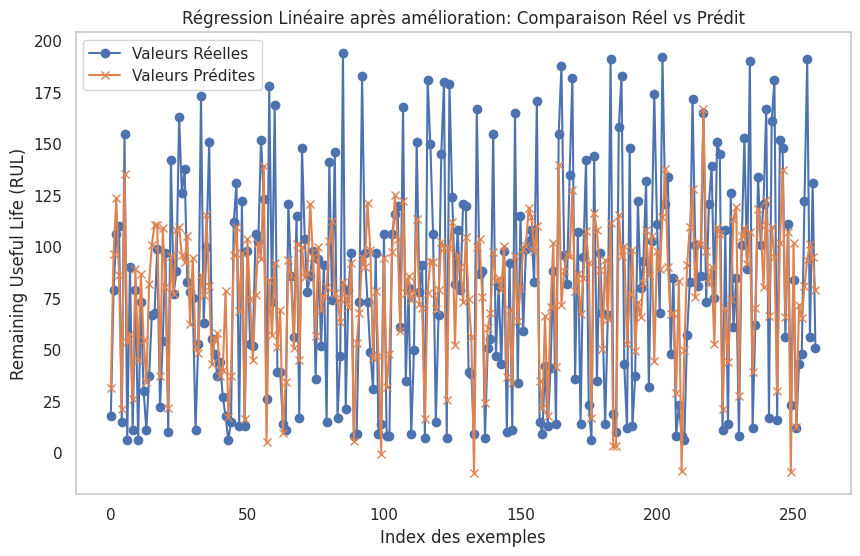

In [ ]:
# Modèle de régression linéaire clipped
from sklearn.linear_model import LinearRegression
y_train_clipped = y_train.clip(upper =125)
lm = LinearRegression()
lm.fit(x_train_trans, y_train_clipped)

# Prédire et évaluer
y_hat_train = lm.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Régression Linéaire après amélioration: Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

## Régression polynomiale

train set RMSE:44.08070381237683, R2:0.5939898746757803
test set RMSE:31.236257725808855, R2:0.662638224009112


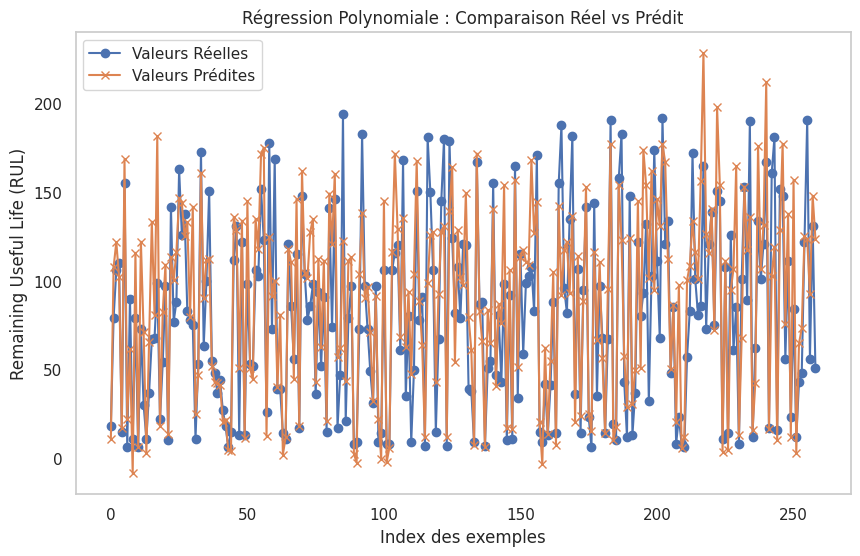

In [ ]:
# Régression polynomiale
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Définir les caractéristiques polynomiales avec un degré de 4
poly_reg = PolynomialFeatures(degree=4)
x_poly = poly_reg.fit_transform(x_train_trans)

# Créer le modèle de régression linéaire
lin_reg_2 = LinearRegression()
lin_reg_2.fit(x_poly, y_train)

# Prédire et évaluer
y_hat_train = lin_reg_2.predict(x_poly)
RMSE_Train, R2_Train = evaluate(y_train, y_hat_train, 'train')

y_hat_test = lin_reg_2.predict(poly_reg.fit_transform(x_test_trans))
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Régression Polynomiale : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

train set RMSE:20.643375091056313, R2:0.7545211045088419
test set RMSE:30.181747728845604, R2:0.6850318432332536


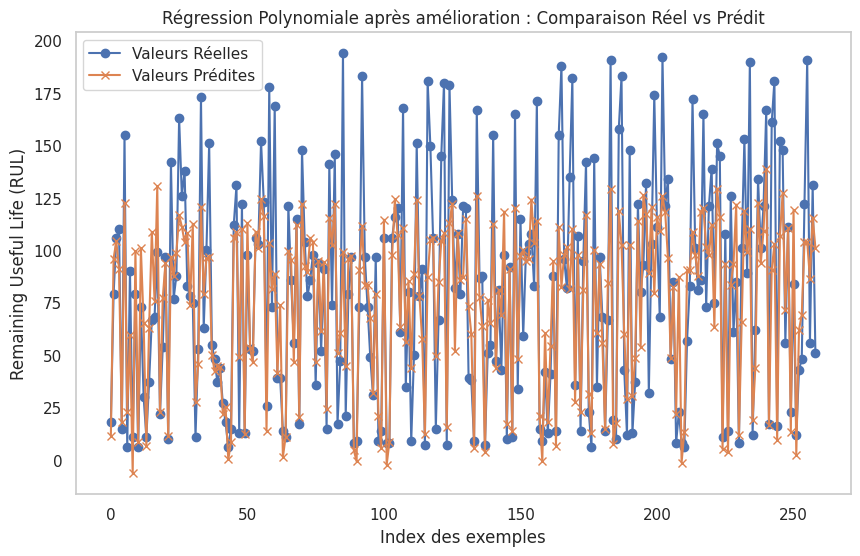

In [ ]:
# Régression polynomiale clipped
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Définir les caractéristiques polynomiales avec un degré de 4
poly_reg = PolynomialFeatures(degree=4)
x_poly = poly_reg.fit_transform(x_train_trans)

# Créer le modèle de régression linéaire
lin_reg_2 = LinearRegression()
lin_reg_2.fit(x_poly, y_train_clipped)

# Prédire et évaluer
y_hat_train = lin_reg_2.predict(x_poly)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lin_reg_2.predict(poly_reg.fit_transform(x_test_trans))
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Régression Polynomiale après amélioration : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

## Régression par Support Vector Machine (SVR)


test set RMSE:55.83872172776252, R2:0.34850549075543136
test set RMSE:38.171283744041816, R2:0.49620783229291765


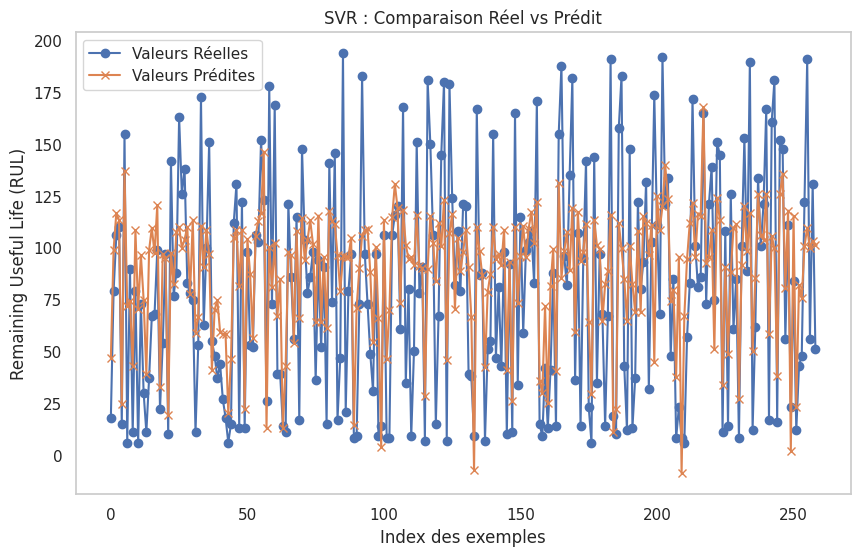

In [ ]:
# SVR
from sklearn.svm import SVR

# Création du modèle
regressor = SVR(kernel='rbf')

# Entraînement
regressor.fit(x_train_trans, y_train)

# Prédictions et évaluation
y_hat_train = regressor.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train, y_hat_train)

y_hat_test = regressor.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("SVR : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#feature engineering
from sklearn.preprocessing import PolynomialFeatures
# 2nd degree polynomialFeatures of [a, b] becomes [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(x_train_trans)
X_test_transformed = poly.fit_transform(x_test_trans)

print(x_train_trans.shape)
print(X_train_transformed.shape)

(53759, 7)
(53759, 36)


In [ ]:
# SVM + clipped RUL + engineered features
# SVR
from sklearn.svm import SVR

# Création du modèle
regressor = SVR(kernel='rbf')

# Entraînement
regressor.fit(X_train_transformed, y_train_clipped)

# Prédictions et évaluation
y_hat_train = regressor.predict(X_train_transformed)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train)

y_hat_test = regressor.predict(X_test_transformed)
RMSE_Train, R2_Train = evaluate(y_test, y_hat_test)


test set RMSE:31.499070743199677, R2:0.428457886296153
test set RMSE:41.33788269245809, R2:0.4091539501843947


In [ ]:
from sklearn.feature_selection import SelectFromModel
# Use 'linear' kernel instead of 'rbf' for feature selection
regressor_linear = SVR(kernel='linear')
regressor_linear.fit(X_train_transformed, y_train_clipped)

select_features = SelectFromModel(regressor_linear, threshold='mean', prefit=True)
select_features.get_support()

# Use get_feature_names_out() instead of get_feature_names() for scikit-learn >= 0.24
try:
    feature_names = poly.get_feature_names_out()  # For scikit-learn >= 0.24
except AttributeError:
    feature_names = poly.get_feature_names()  # For older scikit-learn versions

# Use the original DataFrame variable name (x_train)
print('Original features:\n', x_train.columns)
print('Best features:\n', np.array(feature_names)[select_features.get_support()])
np.array(feature_names)[select_features.get_support()].shape

Original features:
 Index(['s_3', 's_4', 's_11', 's_14', 's_15', 's_16', 's_17'], dtype='object')
Best features:
 ['x1' 'x2' 'x3' 'x4' 'x5' 'x0^2' 'x0 x5' 'x0 x6' 'x1 x5' 'x2^2' 'x2 x3'
 'x2 x4' 'x4 x5' 'x5^2' 'x5 x6' 'x6^2']


(16,)

train set RMSE:29.513153523124547, R2:0.49825392142574143
test set RMSE:39.60743941901367, R2:0.4575853478070374


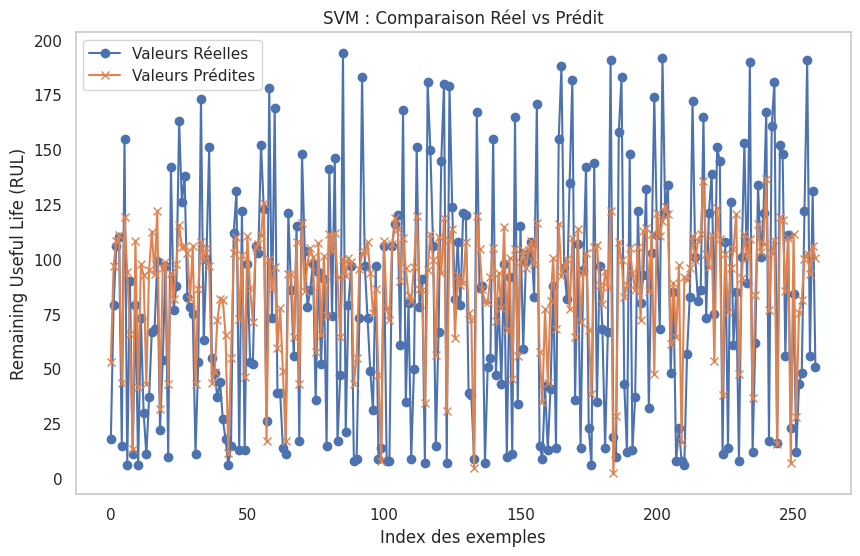

In [ ]:
# SVM regression + clipped RUL + engineered features + selection
svr = SVR(kernel='rbf')
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

# predict and evaluate
y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("SVM : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('Valeur de epsilon par défaut :',svr.epsilon)

Valeur de epsilon par défaut : 0.1


In [ ]:
#Amélioration de SVR (epsilon)
epsilon = [0.4, 0.3, 0.2, 0.1, 0.05]

for e in epsilon:
    svr = SVR(kernel='rbf', epsilon=e)
    svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

    # predict and evaluate
    y_hat = svr.predict(X_train_transformed[:, select_features.get_support()])
    mse = mean_squared_error(y_train_clipped, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_train_clipped, y_hat)
    print("epsilon:", e, "RMSE:", rmse, "R2:", variance)



epsilon: 0.4 RMSE: 29.507004322025583 R2: 0.49846298184439364
epsilon: 0.3 RMSE: 29.506372524800106 R2: 0.49848445920622386
epsilon: 0.2 RMSE: 29.506423083278033 R2: 0.49848274053449604
epsilon: 0.1 RMSE: 29.513153523124547 R2: 0.49825392142574143
epsilon: 0.05 RMSE: 29.514436213707175 R2: 0.4982103070451238


##Régression par Support Vector Machine à kernel linéaire


test set RMSE:24.268981601683343, R2:0.6607218761861418
test set RMSE:34.3383802741914, R2:0.5923030232178746


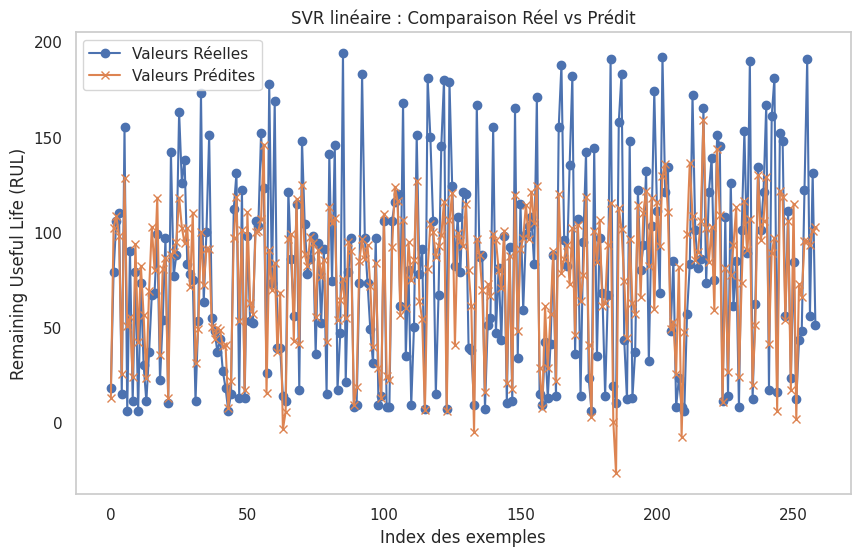

In [ ]:
# SVM lineaire + clipped RUL + engineered features
# SVR
from sklearn.svm import SVR

# Création du modèle
regressor = SVR(kernel='linear')

# Entraînement
regressor.fit(X_train_transformed, y_train_clipped)

# Prédictions et évaluation
y_hat_train = regressor.predict(X_train_transformed)
RMSE_Train, R2_Train = evaluate(y_train_clipped, y_hat_train)

y_hat_test = regressor.predict(X_test_transformed)
RMSE_Train, R2_Train = evaluate(y_test, y_hat_test)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("SVR linéaire : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

## Régression par Decision tree


train set RMSE:39.850165326367254, R2:0.6681818945734994
test set RMSE:34.88945716930089, R2:0.5791122319707456


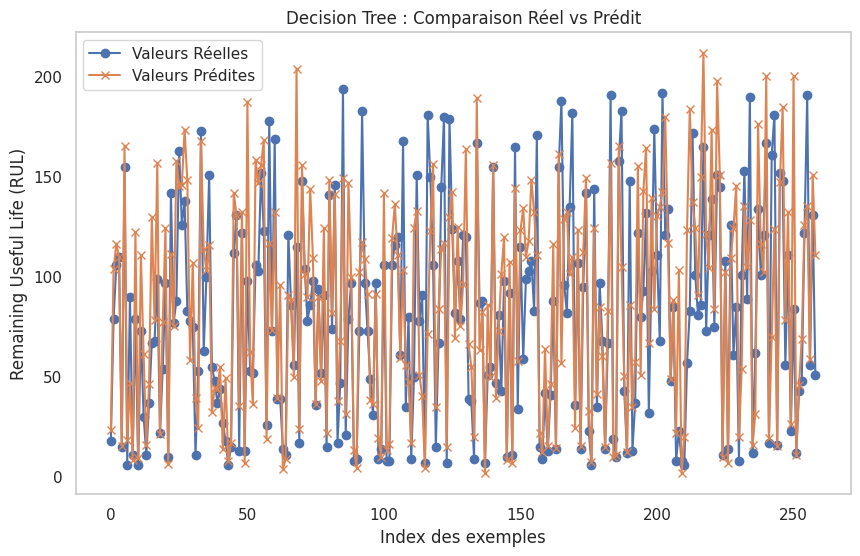

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Création du modèle
dt = DecisionTreeRegressor(random_state=42, max_depth=15, min_samples_leaf=10)

# Entraînement
dt.fit(x_train_trans, y_train)

# Prédictions et évaluation
y_hat_train = dt.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train, y_hat_train, 'train')

y_hat_test = dt.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Decision Tree : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

## Régression par Random forest

train set RMSE:48.195515025239274, R2:0.5146521887167863
test set RMSE:33.590378584573926, R2:0.6098715011633383


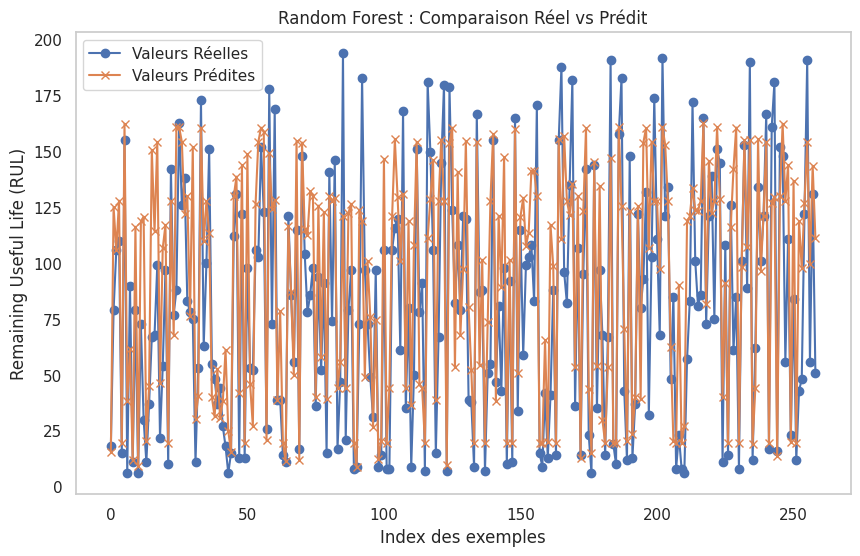

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Création du modèle
rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=6, min_samples_leaf=5)

# Entraînement
rf.fit(x_train_trans, y_train)

# Prédictions et évaluation
y_hat_train = rf.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train, y_hat_train, 'train')

y_hat_test = rf.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("Random Forest : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

## Artificial Neural Network (ANN)

Epoch 1/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 11449.1963
Epoch 2/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4721.6138
Epoch 3/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4533.1045
Epoch 4/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 4305.6377
Epoch 5/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3933.9209
Epoch 6/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3609.2219
Epoch 7/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3235.0581
Epoch 8/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2922.5261
Epoch 9/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2752.5073
Epoch 10/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2639.1243
Epoch 11/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2565.8809
Epoch 12/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2490.7864
Epoch 13/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2456.2385
Epoch 14/75
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - lo

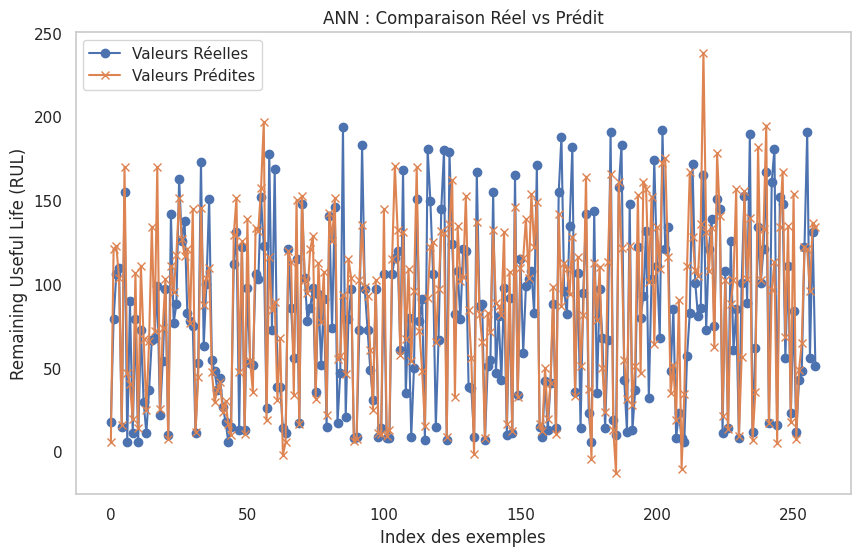

In [ ]:
# Réseau de neurones artificiels (ANN)
import tensorflow as tf

# Création du modèle séquentiel
ann = tf.keras.models.Sequential()

# Ajout des couches cachées avec activation ReLU
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))

# Ajout de la couche de sortie
ann.add(tf.keras.layers.Dense(units=1))

# Compilation du modèle avec l'optimiseur Adam et une fonction de perte MSE
ann.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
ann.fit(x_train_trans, y_train, batch_size=32, epochs=75)

# Prédictions et évaluation pour les données d'entraînement
y_hat_train = ann.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train, y_hat_train, 'train')

# Prédictions et évaluation pour les données de test
y_hat_test = ann.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("ANN : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()

## KNN

Valeur optimale de k: 19 avec RMSE = 31.6289
train set RMSE:42.33316749652594, R2:0.6255435168183884
test set RMSE:31.62886084481256, R2:0.6541044455563052


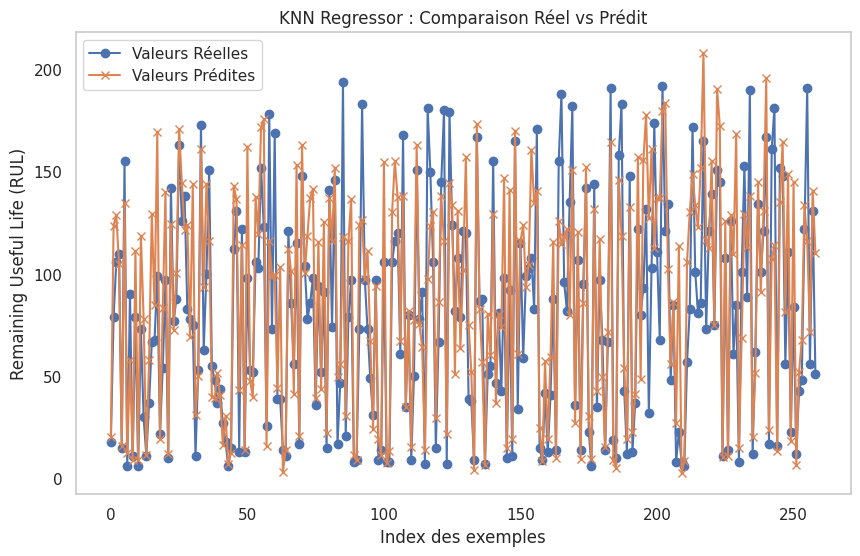

In [ ]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

# Étape 1 : Choisir la valeur optimale de k
k_values = range(1, 21)  # Tester k de 1 à 20
errors = []

# Tester chaque valeur de k
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train_trans, y_train)
    y_pred = knn.predict(x_test_trans)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    errors.append(rmse)

# Déterminer la valeur optimale de k
optimal_k = k_values[np.argmin(errors)]
print(f"Valeur optimale de k: {optimal_k} avec RMSE = {min(errors):.4f}")

# Étape 2 : Création du modèle avec k optimal
knn = KNeighborsRegressor(n_neighbors=optimal_k)

# Entraînement
knn.fit(x_train_trans, y_train)

# Prédictions et évaluation pour les données d'entraînement
y_hat_train = knn.predict(x_train_trans)
RMSE_Train, R2_Train = evaluate(y_train, y_hat_train, 'train')

# Prédictions et évaluation pour les données de test
y_hat_test = knn.predict(x_test_trans)
RMSE_Test, R2_Test = evaluate(y_test, y_hat_test, 'test')

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valeurs Réelles', marker='o')
plt.plot(range(len(y_test)), y_hat_test, label='Valeurs Prédites', marker='x')
plt.title("KNN Regressor : Comparaison Réel vs Prédit")
plt.xlabel("Index des exemples")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid()
plt.show()